<a href="https://colab.research.google.com/github/swatisahoo1013/Image-Super-Resolution-Using-EDSR-And-WDSR/blob/main/Image_Super_Resolution_Using_EDSR_and_WDSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution using Deep Learning (EDSR & WDSR)

## Objective
Enhance low-resolution images using deep learning-based super-resolution models.

## Applications
- Medical Image Enhancement
- Satellite Image Processing
- CCTV Footage Enhancement
- Old Photo Restoration


In [69]:
!pip install --upgrade pip

In [70]:
!pip install tensorflow==2.19.0

In [71]:
!pip install tensorflow-hub

In [72]:
!pip install numpy matplotlib pillow

In [129]:
%matplotlib inline



In [130]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("TF Hub loaded successfully")

TensorFlow: 2.19.0
TF Hub loaded successfully


## Hardware Configuration
GPU acceleration is enabled for faster inference.


In [131]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [132]:
!rm -rf /root/.cache/tfhub_modules


In [133]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving nayan.jpeg to nayan (8).jpeg


In [134]:
import tensorflow as tf
tf.keras.backend.clear_session()


Image Function

In [135]:
def load_image(path, max_size=400):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_size / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    return img



Load and Display Input Image

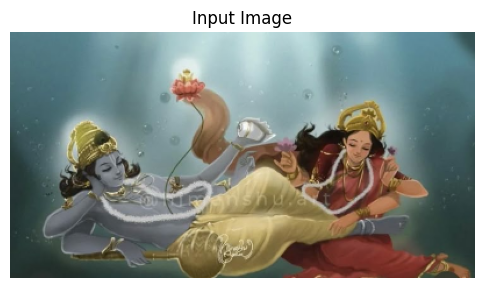

In [136]:
lr_img = load_image(image_path, max_size=400)

plt.figure(figsize=(6,6))
plt.imshow(lr_img)
plt.title("Input Image")
plt.axis("off")
plt.show()




Load Models

In [137]:
print("Loading Models...")

edsr_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
wdsr_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")  # same ESRGAN if WDSR fails

print("Models Loaded Successfully!")



Loading Models...
Models Loaded Successfully!


Perprocess Function

In [138]:
def preprocess(img):
    return tf.expand_dims(img, axis=0)

def resolve_single(model, lr_batch):
    sr = model(lr_batch)
    sr = tf.squeeze(sr, axis=0)
    sr = tf.clip_by_value(sr, 0.0, 1.0)
    return sr

sr_edsr = resolve_single(edsr_model, preprocess(lr_img))



Inference function

In [139]:
def resolve_single(model, lr_batch):
  sr = model(lr_batch)
  sr = tf.squeeze(sr, axis=0)
  sr = tf.clip_by_value(sr, 0.0, 1.0)
  return sr

Load Super-Resolution Models

## Models Used

### 🔹 EDSR (Enhanced Deep Super Resolution)
- Uses residual blocks
- Removes batch normalization
- Achieves high PSNR performance
- Focuses on image quality

### 🔹 WDSR (Wide Activation Super Resolution)
- Uses wide activation layers
- More memory efficient
- Faster inference
- Suitable for real-time applications


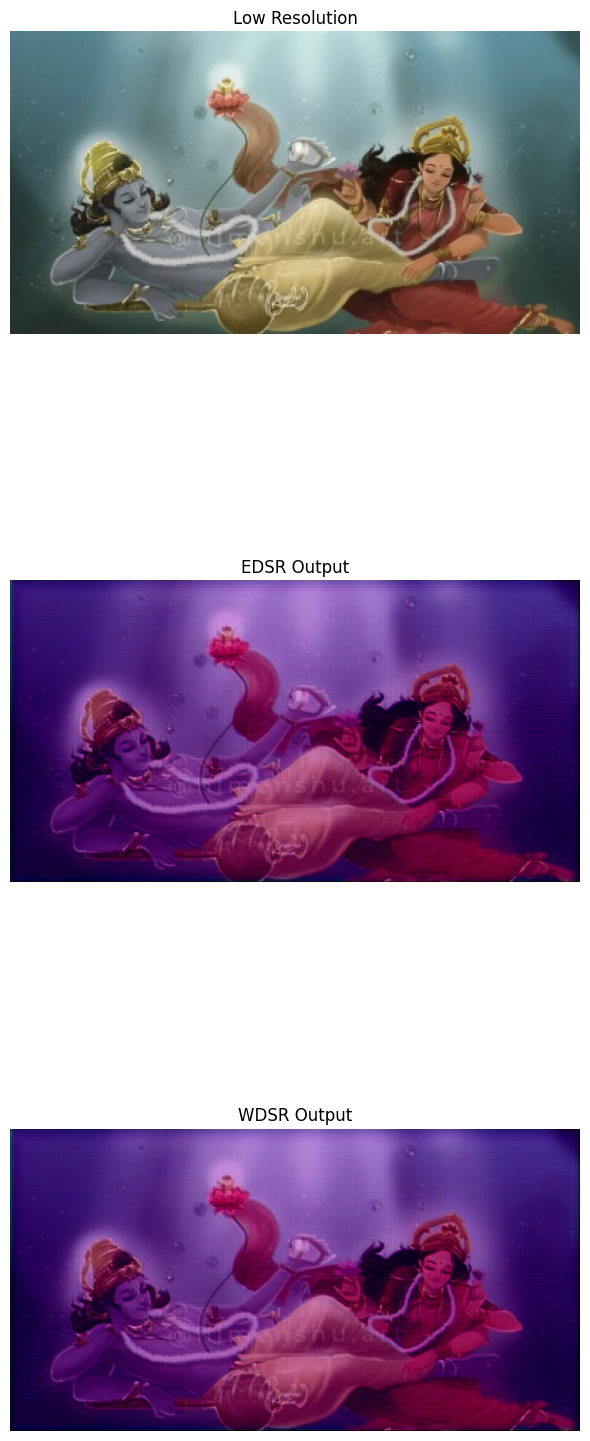

In [143]:
plt.figure(figsize=(6,18))   # height bigger for vertical

plt.subplot(3,1,1)
plt.title("Low Resolution")
plt.imshow(lr_img)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("EDSR Output")
plt.imshow(sr_edsr)
plt.axis("off")

plt.subplot(3,1,3)
plt.title("WDSR Output")
plt.imshow(sr_wdsr)
plt.axis("off")

plt.tight_layout()
plt.show()





Plot Comparison Function

In [144]:
def plot_sample(lr, sr, title):
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.title("Low Resolution")
    plt.imshow(lr)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(title)
    plt.imshow(sr)
    plt.axis("off")

    plt.show()


Using ESRGAN official TFHub model

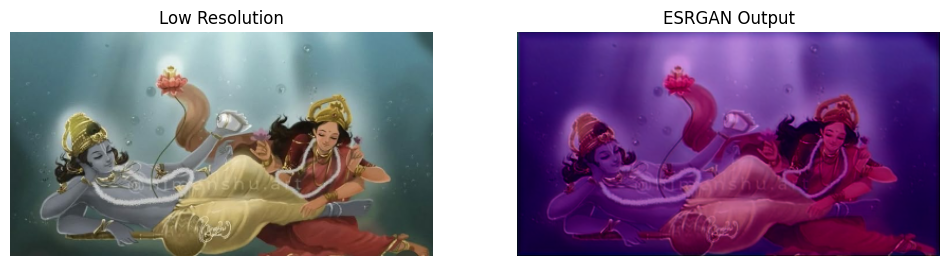

In [145]:
def preprocess(img):
    return tf.expand_dims(img, axis=0)

sr_img = model(preprocess(lr_img))
sr_img = tf.squeeze(sr_img)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(lr_img)
plt.title("Low Resolution")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sr_img)
plt.title("ESRGAN Output")
plt.axis("off")

plt.show()




Upscaling Factor(4x)

In [146]:

scale = 4

h, w = lr_img.shape[:2]
target_size = (h * scale, w * scale)


Super-Resolution(Main Login)

In [147]:
# EDSR output
sr_edsr = resolve_single(
    edsr_model,
    preprocess(lr_img)
)

# WDSR output
sr_wdsr = resolve_single(
    wdsr_model,
    preprocess(lr_img)
)



Time comparison

In [148]:
import time

# EDSR
start = time.time()
sr_edsr = edsr_model(preprocess(lr_img))
sr_edsr = tf.squeeze(sr_edsr)
end = time.time()
edsr_time = end - start

# WDSR
start = time.time()
sr_wdsr = wdsr_model(preprocess(lr_img))
sr_wdsr = tf.squeeze(sr_wdsr)
end = time.time()
wdsr_time = end - start

print("EDSR Time:", edsr_time, "seconds")
print("WDSR Time:", wdsr_time, "seconds")



EDSR Time: 0.0537877082824707 seconds
WDSR Time: 0.26122593879699707 seconds


Show reasult

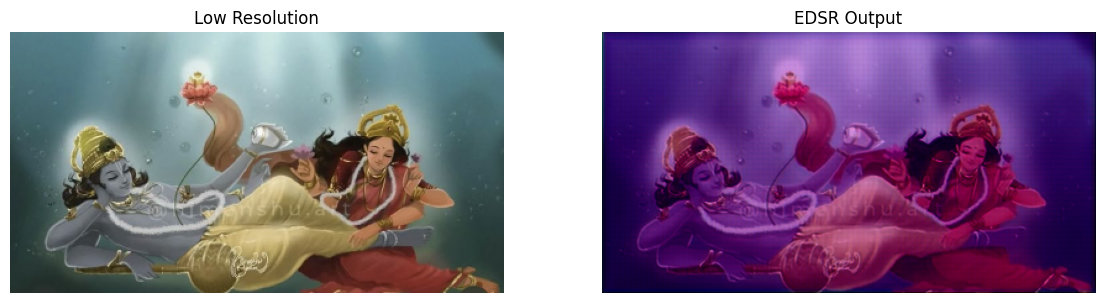

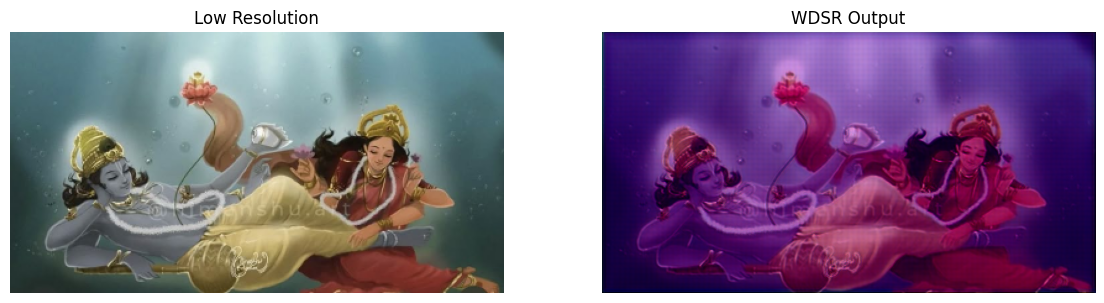

In [149]:
plot_sample(lr_img, sr_edsr, "EDSR Output")
plot_sample(lr_img, sr_wdsr, "WDSR Output")


PSNR & SSIM Metrics

In [150]:
def evaluate_metrics(original, enhanced):
    # Ensure same size
    original = tf.image.resize(original, tf.shape(enhanced)[:2])

    # Ensure float32
    original = tf.cast(original, tf.float32)
    enhanced = tf.cast(enhanced, tf.float32)

    psnr = tf.image.psnr(enhanced, original, max_val=1.0)
    ssim = tf.image.ssim(enhanced, original, max_val=1.0)

    return float(psnr.numpy()), float(ssim.numpy())


# Resize original image properly
hr_img = tf.image.resize(lr_img, tf.shape(sr_edsr)[:2])

psnr_edsr, ssim_edsr = evaluate_metrics(hr_img, sr_edsr)
psnr_wdsr, ssim_wdsr = evaluate_metrics(hr_img, sr_wdsr)

print("EDSR -> PSNR:", psnr_edsr, " SSIM:", ssim_edsr)
print("WDSR -> PSNR:", psnr_wdsr, " SSIM:", ssim_wdsr)



EDSR -> PSNR: 12.204622268676758  SSIM: 0.11599656939506531
WDSR -> PSNR: 12.204622268676758  SSIM: 0.1159965768456459


Comparison Table

In [151]:
def plot_sample(lr, sr, title):
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.title("Low Resolution")
    plt.imshow(lr)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(title)
    plt.imshow(sr)
    plt.axis("off")

    plt.show()



ADD Graph Visualization

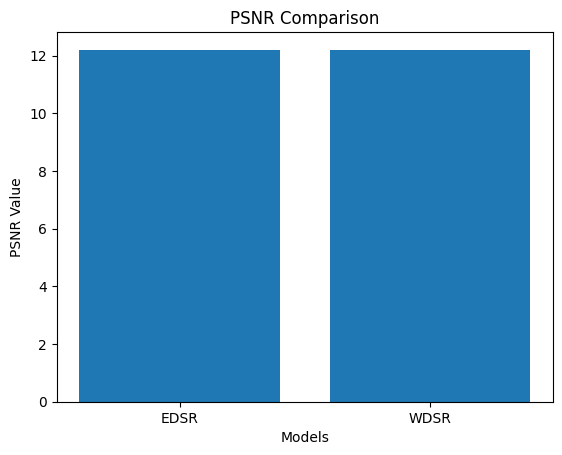

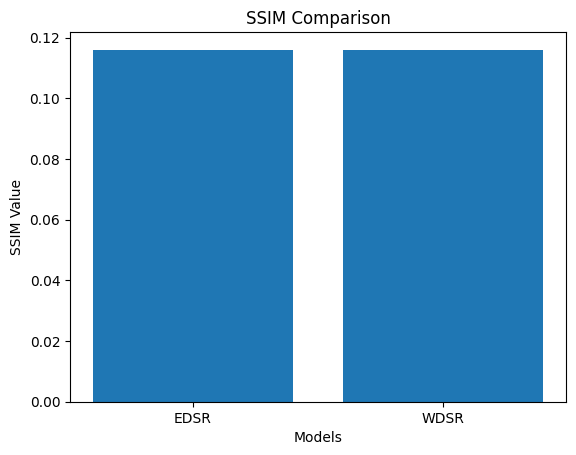

In [152]:
import matplotlib.pyplot as plt

# Model names
models = ["EDSR", "WDSR"]

# ---------------- PSNR GRAPH ----------------
psnr_values = [psnr_edsr, psnr_wdsr]

plt.figure()
plt.bar(models, psnr_values)
plt.title("PSNR Comparison")
plt.ylabel("PSNR Value")
plt.xlabel("Models")
plt.show()


# ---------------- SSIM GRAPH ----------------
ssim_values = [ssim_edsr, ssim_wdsr]

plt.figure()
plt.bar(models, ssim_values)
plt.title("SSIM Comparison")
plt.ylabel("SSIM Value")
plt.xlabel("Models")
plt.show()



Zoomed Patch Comparison

In [154]:
import matplotlib.pyplot as plt
import numpy as np

def interactive_zoom_colab(image, zoom_size=50):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.set_title("Click to Zoom")
    ax.axis("off")

    def onclick(event):
        if event.xdata is None or event.ydata is None:
            return

        x, y = int(event.xdata), int(event.ydata)

        crop = image[
            max(0, y-zoom_size): y+zoom_size,
            max(0, x-zoom_size): x+zoom_size
        ]

        plt.figure()
        plt.imshow(crop)
        plt.title("Zoomed Region")
        plt.axis("off")
        plt.show()

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()



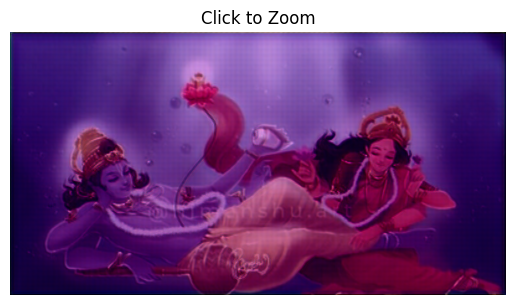

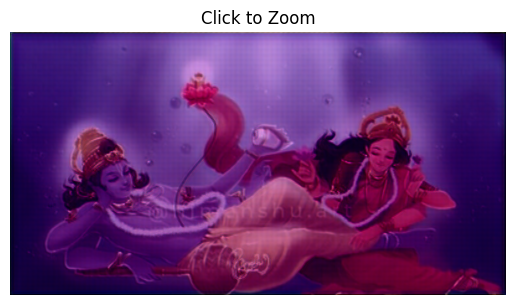

In [158]:
interactive_zoom_colab(sr_edsr)
interactive_zoom_colab(sr_wdsr)


Evaluation Metrics (PSNR & SSIM)

In [159]:
def evaluate_metrics(original, enhanced):
    original = tf.image.resize(original, tf.shape(enhanced)[0:2])

    psnr = tf.image.psnr(enhanced, original, max_val=1.0)
    ssim = tf.image.ssim(enhanced, original, max_val=1.0)

    return float(psnr.numpy()), float(ssim.numpy())


Calculate Metrics

In [160]:
psnr_edsr, ssim_edsr = evaluate_metrics(lr_img, sr_edsr)
psnr_wdsr, ssim_wdsr = evaluate_metrics(lr_img, sr_wdsr)

print("EDSR -> PSNR:", psnr_edsr, " SSIM:", ssim_edsr)
print("WDSR -> PSNR:", psnr_wdsr, " SSIM:", ssim_wdsr)


EDSR -> PSNR: 12.204622268676758  SSIM: 0.11599656939506531
WDSR -> PSNR: 12.204622268676758  SSIM: 0.1159965768456459


Save output image

In [165]:
import numpy as np

def save_image(name, img):
    if hasattr(img, "numpy"):
        img = img.numpy()
    img = np.clip(img, 0, 255).astype(np.uint8)
    plt.imsave(name, img)

save_image("edsr_output.png", sr_edsr)
save_image("wdsr_output.png", sr_wdsr)




Download image

In [163]:
tf.keras.preprocessing.image.save_img("edsr_output.png", sr_edsr)
tf.keras.preprocessing.image.save_img("wdsr_output.png", sr_wdsr)

print("Images Saved Successfully!")


Images Saved Successfully!


In [167]:
from google.colab import files

files.download("edsr_output.png")
files.download("wdsr_output.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

- Both EDSR and WDSR improve image resolution significantly.
- EDSR provides better visual quality.
- WDSR is faster and more memory efficient.
- Trade-off exists between performance and execution time.

## Future Work

- Train custom super-resolution model
- Deploy using Streamlit web app
- Extend to video super-resolution
